In [1]:
# Imports
import numpy as np

User-specified parameters

In [2]:
## User-params
denPts = 3  #No. of density samples for training
H = 1000 #No. of gradient samples for training
N = 75 #Grid dimensions for original grid and also used for testing grid (Xnew)

In [3]:
subset = 5 #If uniform sampling for training, use this subset

Load images

(256, 513)
Img rho shape: (256, 513)
rho_indicies shape: (2, 256, 513)


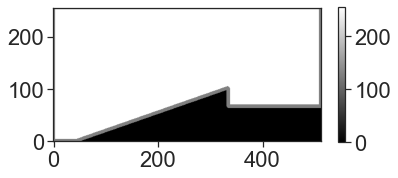

In [4]:
%load_ext autoreload
%autoreload 2
from Case2helper import image

# Initialise case
case = image(randseed=1, prescale=200)

# Read in density and gradient images
case.read_images(N=N)

# Mask solid region
case.mask_geometry()

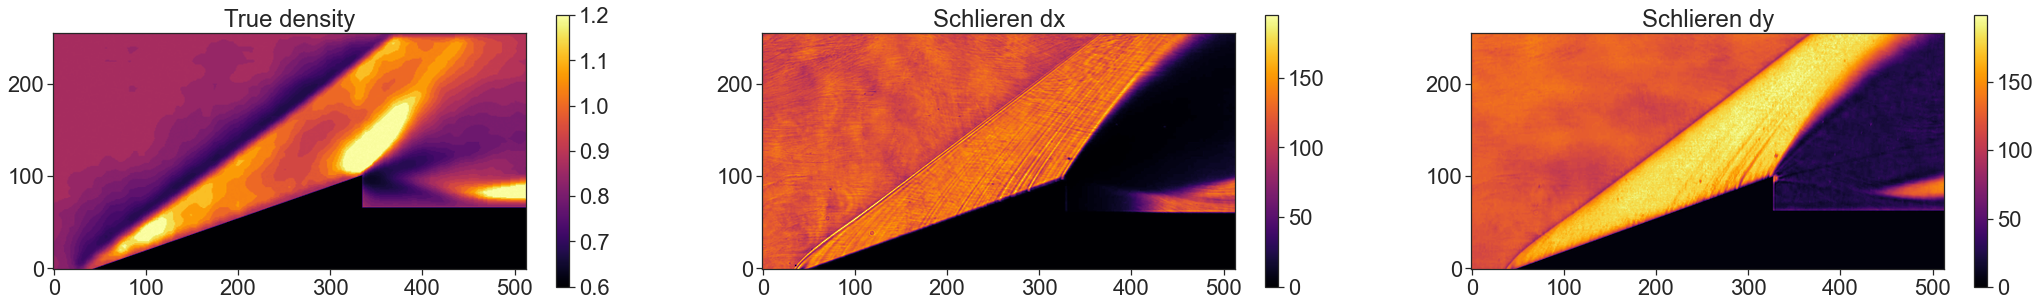

In [5]:
# Plot input density & pixel normalised gradients
case.plot_true_grads()

vals shape: (5356, 1)
No. of training points:  4249
yshape (4249, 2, 1)


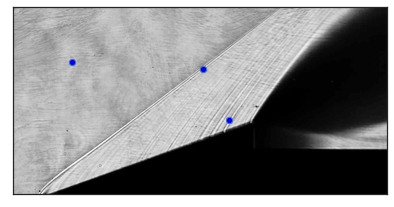

In [6]:
Ms, us = case.gen_subsample_pts(step=subset, mask_geom=True)   # Subsample original grid

# Generate grid for testing
case.gen_test_grid(step=subset)

# # Get random density values automatically for training
# X_f, f = case.get_ran_density(npts=denPts)

X_f = np.array([
    [80, 180],
    [259, 168],
    [294, 98],
])

# # Get nearest points from subsampled density image.
X_f = case.get_nearest(X_f)

# When sampling dataset, need to pass in y index first, then x index
f = np.c_[ case.density_scaled[X_f[:,1], X_f[:,0]] ]
case.X_f = X_f
case.f = f

case.plot_sampling_pts(savefile="exports/case2_sampling.jpg")

# Gradient Enhanced Kriging
__________________

# Using Gradient-Based Kriging (Input dx and dy)
___

In [7]:
import pymc3 as pm
import schlierenPymc3 as spm
import theano.tensor as tt

sigma_y, sigma_dy = 2.5E-4, 0.25

with pm.Model() as model:

    # Define hyperparameters
    bx = by = c = 0.0

    ls = pm.HalfNormal("ls", sigma=1, shape=2)
    lamda = pm.HalfNormal("lamda", sigma=1, shape=2)

    alphas = tt.stack([lamda[0] * lamda[1]/tt.square(ls[0]) , \
                         lamda[1] * lamda[0]/tt.square(ls[1])])

    xi = pm.HalfNormal("xi", sigma=1)
    sigma_f = tt.sqrt(xi/(lamda[0] * lamda[1]))
    kappa = pm.HalfNormal("kappa", sigma=2)

    data = np.r_[
                us[:, 0] - np.average(us[:, 0]), \
                us[:, 1] - np.average(us[:, 1]), 
                f.ravel() - np.average(f)
                ]

    print("No. of function values: ", len(X_f))
    print("No. of gradient values: ", len(Ms))
    print("Data length: ", len(data))

    mean_func = spm.gp.mean.SchlierenNorm(bx=bx, by=by, c=c)
    cov_gek = spm.gp.cov.NormGEK(input_dim=2, ls=ls, \
                                 sigma_f=sigma_f, alphas=alphas, kappa=kappa)
    gp = spm.gp.MarginalNormGEK(mean_func=mean_func, cov_func=cov_gek)
    y_ = gp.marginal_likelihood("y_",
                                X=X_f,  #Function value locations
                                X_df=Ms,  #Gradient value locations
                                y=data,
                                noise_y=sigma_y,    #Input function noise
                                noise_dy=sigma_dy)  #Input gradient noise

No. of function values:  3
No. of gradient values:  4249
Data length:  8501


In [8]:
# Inference
mu_s, cov_s = case.infer(model=model, gp=gp, method="map")


{'ls_log__': array([-0.21010783, -0.28773659]), 'lamda_log__': array([2.44936929, 2.44936929]), 'xi_log__': array(2.35787225), 'kappa_log__': array(-40.11901284), 'ls': array([0.81049685, 0.74995911]), 'lamda': array([11.58104015, 11.58104015]), 'xi': array(10.56844046), 'kappa': array(3.77167363e-18)}


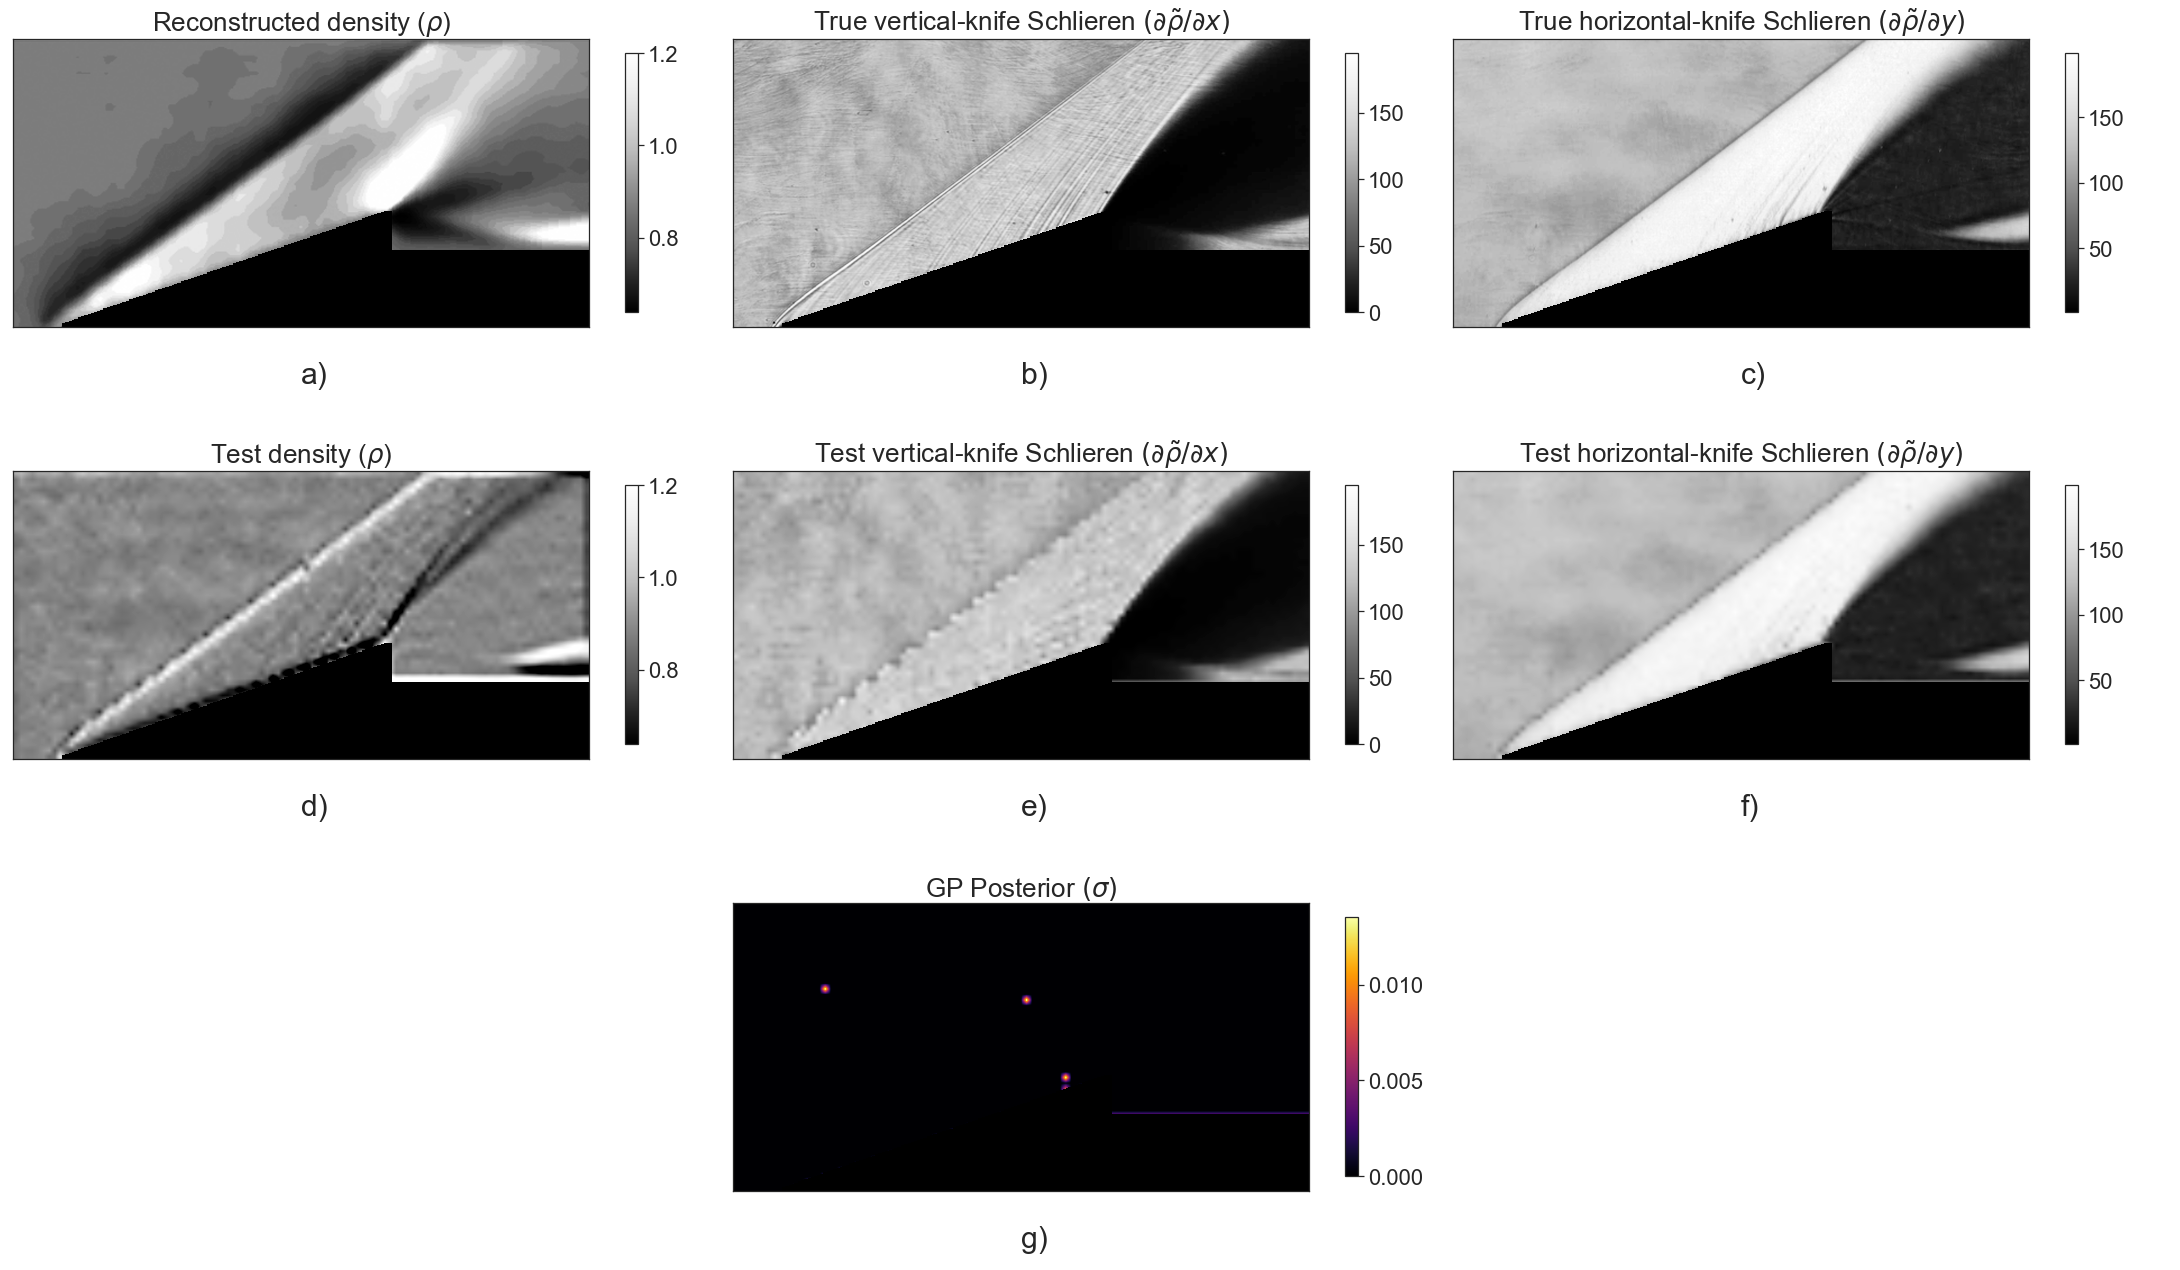

In [9]:
case.plot_posterior(savefile="exports/case2/prediction")

In [10]:
case.save_results(filepath="exports/case2/results.vtk")